## Data Extraction

In [111]:
import gzip
import shutil
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from mnist import MNIST
import os
import glob
from sklearn import metrics

In [112]:
# Create data directory to extract files
def create_data_dir():
    try:
        parent_dir = '.'
        directory = 'data'
        path = os.path.join(parent_dir, directory)
        os.mkdir(path)
    except FileExistsError:
        pass

create_data_dir()

In [113]:
# Extract gz files

source_dir = "."
dest_dir = "./data"
tmpfile = "/tmp/delete.me"

for src_name in glob.glob(os.path.join(source_dir, '*.gz')):
    base = os.path.basename(src_name)
    dest_name = os.path.join(dest_dir, base[:-3])
    shutil.copyfile(src_name, tmpfile)
    with gzip.open(tmpfile, 'rb') as infile:
        with open(dest_name, 'wb') as outfile:
            for line in infile:
                outfile.write(line)

In [114]:
# Load training data

mndata = MNIST('data')

tr_images, tr_labels = mndata.load_training()
# or
ts_images, ts_labels = mndata.load_testing()

In [115]:
# Covert to numpy arrays
tr_labels = np.asarray(tr_labels)
tr_images = np.asarray(tr_images)

In [116]:
tr_images.shape

(60000, 784)

# Task 1

#### The images are 28 x 28 pixels in gray-scale. The categories are 0, 1, ... 9. Concatenate the image rows into a 28 x 28 vector and treat this as your feature, and assume the feature vectors in each category in the training data (”train-images-idx3-ubyte.gz”) have Gaussian distribution. Draw the mean and standard deivation of those features for the 10 categories as 28 x 28 images using the training images (”train-images-idx3-ubyte.gz”). There should be 2 images for each of the 10 digits, one for mean and one for standard deviation. We call those ”mean digits” and ”standard deviation digits”.
## Creating 'mean images' and 'standard deviation images'

In [117]:
# Compute mean of pixels of all categories
def compute_mean(data, label):
    mean = []
    for num in range(10):
        mean.append(np.mean(tr_images[tr_labels==num], axis=0))
    return mean

mean_img = compute_mean(tr_images, tr_labels)
mean_img = np.asarray(mean_img)

In [118]:
# Compute mean of pixels of all categories
def compute_std(data, label):
    std = []
    for num in range(10):
        std.append(np.std(tr_images[tr_labels==num], axis=0))
    return std

std_img = compute_std(tr_images, tr_labels)
std_img = np.asarray(std_img)

## Plotting 'mean images'

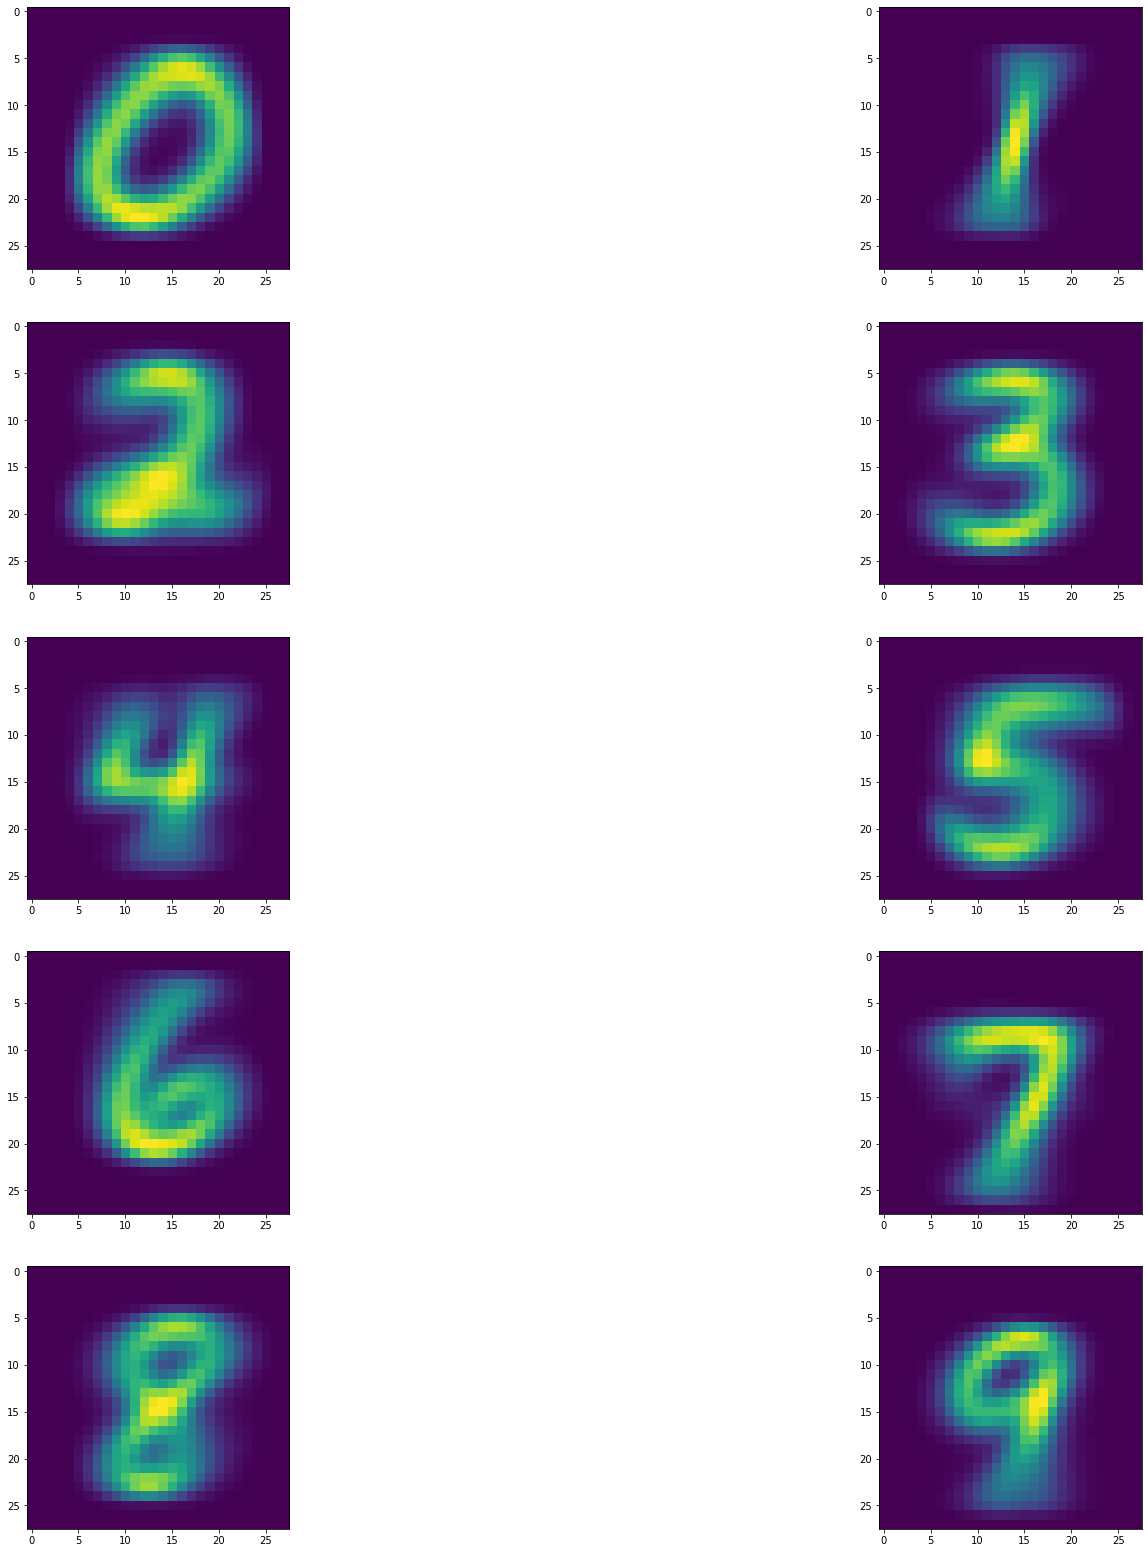

In [119]:
# Plot 'mean images'
_, axs = plt.subplots(5, 2, figsize=(28, 28))
for ax, num in zip(axs.ravel(), range(10)):
    img = np.reshape(mean_img[num], (28, 28))
    ax.imshow(img)

## Plotting 'standard deviation images'

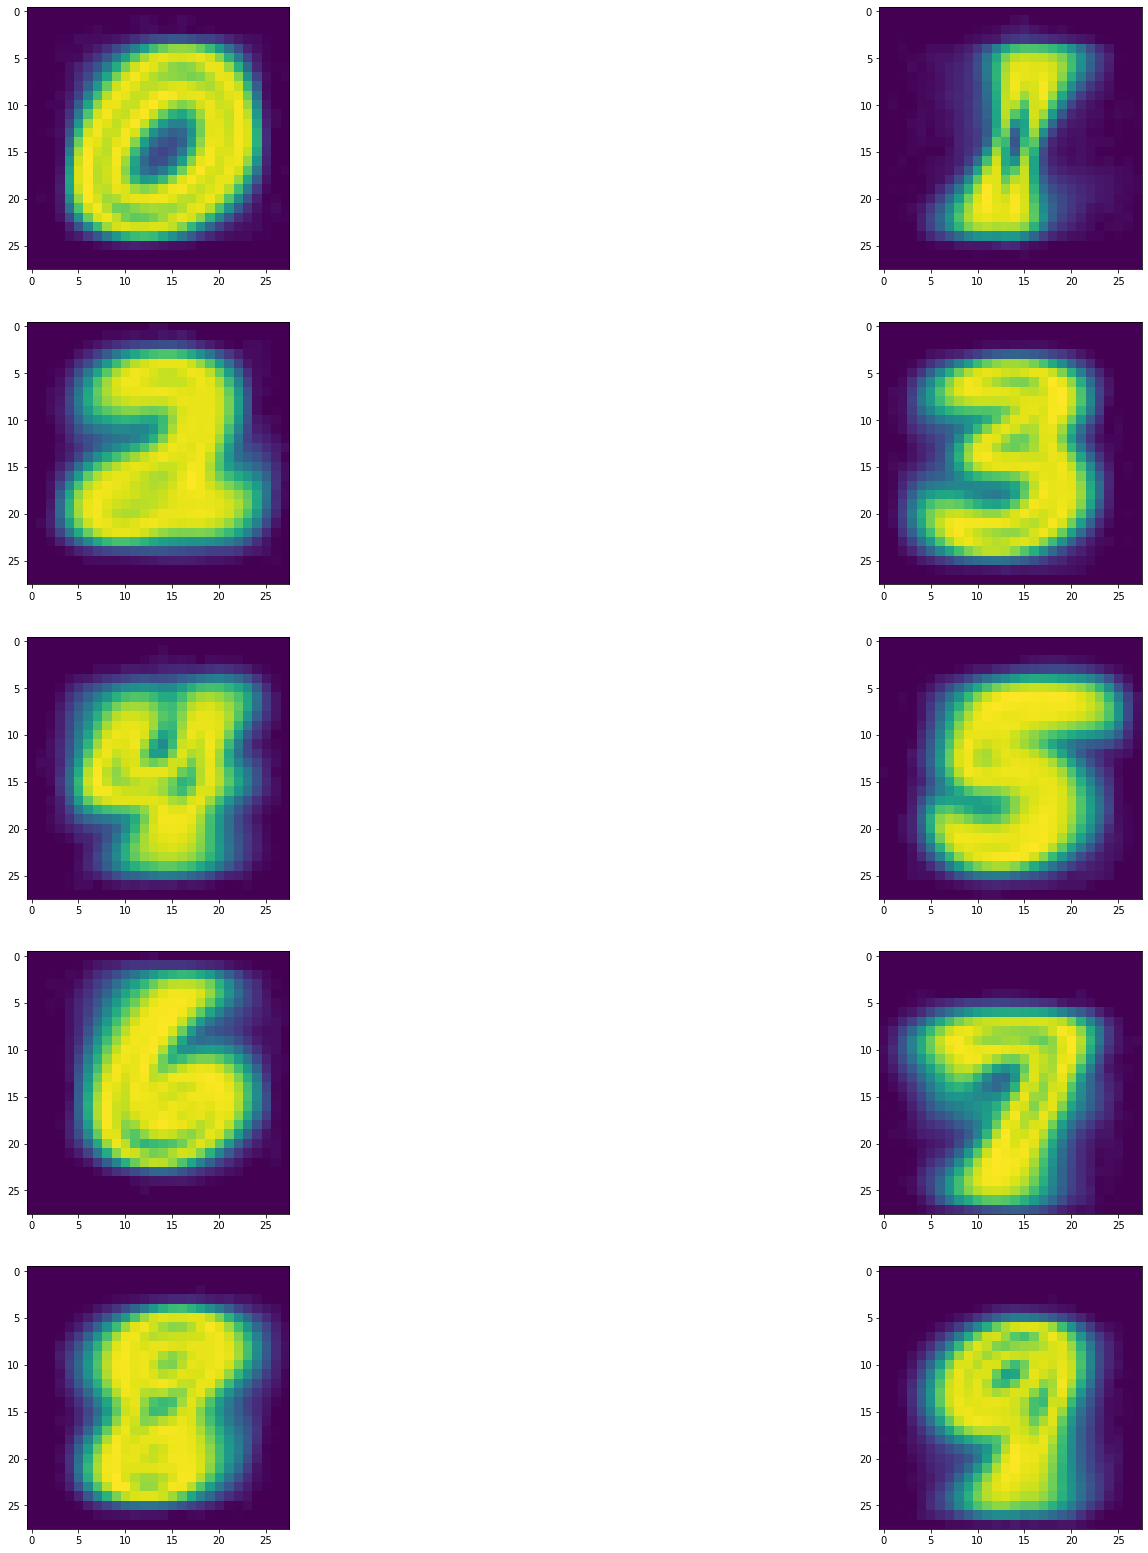

In [120]:
# Plot 'mean images'
_, axs = plt.subplots(5, 2, figsize=(28, 28))
for ax, num in zip(axs.ravel(), range(10)):
    img = np.reshape(std_img[num], (28, 28))
    ax.imshow(img)

# Task 2

#### Classify the images in the testing data set (”t10k-images-idx3-ubyte.gz”) using 0-1 loss function and Bayesian Decision Rule and report the performance. Before coding the discriminant functions, review Section 2.6 in textbook ”Pattern Classification by Richard O. Duda, Peter E. Hart and David G. Stork”. Answer the question: Why it doesn’t perform as good as many other methods on LeCun’s web page?

In [121]:
# Calculate prior p(w)
total_observations = tr_images.shape[0]
prior = []
for digit in range(10):
    prior.append(tr_images[tr_labels==digit].shape[0]/total_observations)
prior = np.asarray(prior)
print(prior)

[0.09871667 0.11236667 0.0993     0.10218333 0.09736667 0.09035
 0.09863333 0.10441667 0.09751667 0.09915   ]


### Covariance, Covariance inverse and log(covarience inverse)

In [103]:
# Sigma, sigma inverse, and sigma determinant
sigma = []
sigma_inv = []
sigma_log_det = []

# 784 x 784 Identity matrix
I = np.identity(784)

for i in range(10):
    #sigma.append(np.cov(tr_images[tr_labels==i].T))
    sigma.append(np.cov(mean_img[i].T))
    sigma[i] += I*1e-6
    sigma_log_det.append(np.linalg.slogdet(sigma[i])[1])
    sigma_inv.append(np.linalg.inv(sigma[i]))
sigma = np.asarray(sigma)
sigma_inv = np.asarray(sigma_inv)
sigma_log_det = np.asarray(sigma_log_det)
print(sigma_log_det)

[ -449.64424035 -1577.05266285   729.99739507    85.36513499
   159.15199906   211.12198553  -532.91039105  -120.85541537
  -224.10179811  -733.96542173]


In [102]:
tr_images[tr_labels==7].shape

(6265, 784)

In [89]:
tr_images.shape

(60000, 784)

### Discriminant function

In [104]:
W = np.zeros((10, 784, 784))
w = np.zeros((10, 784, 1))
for num in range(10):
    W[num] = (-0.5) * sigma_inv[num]
    w[num] = np.matmul(sigma_inv[num], mean_img[[i]].T)
    w0 = (-(1/2)*np.matmul(np.matmul(mean_img[[num]], sigma_inv), mean_img[[num]].T)) - (1/2)*sigma_log_det[num] + np.log(prior[num])

In [58]:
ts_images = np.asarray(ts_images)
ts_labels = np.asarray(ts_labels)

In [85]:
def max_discriminant(x):
    g = []
    for num in range(10):
        g.append(np.matmul(np.matmul(x, W[num].T), x.T) + np.matmul(w[num].T, x.T) + w0[num])

    return g.index(max(g))

## Prediction

In [105]:
# Prediction

pred = np.apply_along_axis(max_discriminant, axis=1, arr=ts_images)

## Evaluation

### Confusion Matrix

In [106]:
pred[pred==9].shape

(6953,)

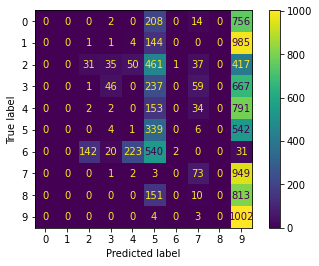

In [107]:
cm = metrics.confusion_matrix(ts_labels, pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()